## Praktikum 1

RNN untuk Analisis Sentimen

## Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label)

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I can't figure out how anyone can get a budget for a movie this bad. It's like the TV station are desperate for anything, anything at all. They're buried underneath a bunch of snow, the electricity constantly flashes on and off, yet magically there is a background light that stays constant. Where does all this (fake) light come from? That, and all that stupid bickering between the characters. They seem to be more interested in complaining to each other than trying to invent ways to survive. It tries to create that feel of emergency and people helping. But because it's such bad directing and acting, you will not your Florence Nightingale fix with this flick, sorry. I'm joining the negative feedback, and I concur that this is one of the worst movies ever."
 b'Wasn\'t quite sure what to expect with this one, outside of the uniform positive reviews I\'ve read. Turns out, I could have never imagined this movie, because it\'s very close to "The Bride with White Hair" in being oper

#Buat Teks Encoder
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 175, 811, ...,   0,   0,   0],
       [268, 176, 243, ...,   0,   0,   0],
       [ 10,   1,  58, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

* Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
* Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I can't figure out how anyone can get a budget for a movie this bad. It's like the TV station are desperate for anything, anything at all. They're buried underneath a bunch of snow, the electricity constantly flashes on and off, yet magically there is a background light that stays constant. Where does all this (fake) light come from? That, and all that stupid bickering between the characters. They seem to be more interested in complaining to each other than trying to invent ways to survive. It tries to create that feel of emergency and people helping. But because it's such bad directing and acting, you will not your Florence Nightingale fix with this flick, sorry. I'm joining the negative feedback, and I concur that this is one of the worst movies ever."
Round-trip:  i cant figure out how anyone can get a budget for a movie this bad its like the tv [UNK] are [UNK] for anything anything at all theyre [UNK] [UNK] a bunch of [UNK] the [UNK] [UNK] [UNK] on and off yet [UNK] th

#Buat Model

In [12]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
for i, layer in enumerate(model.layers):
    print(f"Lapisan {i}: {layer}")

Lapisan 0: <keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7a3964ee1ed0>
Lapisan 1: <keras.src.layers.core.embedding.Embedding object at 0x7a39650180d0>
Lapisan 2: <keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7a396501b520>
Lapisan 3: <keras.src.layers.core.dense.Dense object at 0x7a3965019990>
Lapisan 4: <keras.src.layers.core.dense.Dense object at 0x7a39650197e0>


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-8.569253e-05]


In [14]:
  # predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 350ms/step
[-8.569262e-05]


  compile model Keras untuk mengonfigurasi proses pelatihan:

In [15]:

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Train Model

In [16]:

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 724s 2s/step - loss: 0.6468 - accuracy: 0.5676 - val_loss: 0.4984 - val_accuracy: 0.7047
Epoch 2/10
391/391 [==============================] - 711s 2s/step - loss: 0.4194 - accuracy: 0.8010 - val_loss: 0.3781 - val_accuracy: 0.8156
Epoch 3/10
391/391 [==============================] - 695s 2s/step - loss: 0.3482 - accuracy: 0.8464 - val_loss: 0.3435 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 697s 2s/step - loss: 0.3232 - accuracy: 0.8591 - val_loss: 0.3306 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 697s 2s/step - loss: 0.3173 - accuracy: 0.8628 - val_loss: 0.3237 - val_accuracy: 0.8521
Epoch 6/10
391/391 [==============================] - 689s 2s/step - loss: 0.3078 - accuracy: 0.8688 - val_loss: 0.3247 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 696s 2s/step - loss: 0.3049 - accuracy: 0.8681 - val_loss: 0.3243 - val_accuracy: 0.8516

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 167s 427ms/step - loss: 0.3141 - accuracy: 0.8572
Test Loss: 0.31409505009651184
Test Accuracy: 0.857200026512146


(0.0, 0.6641503155231476)

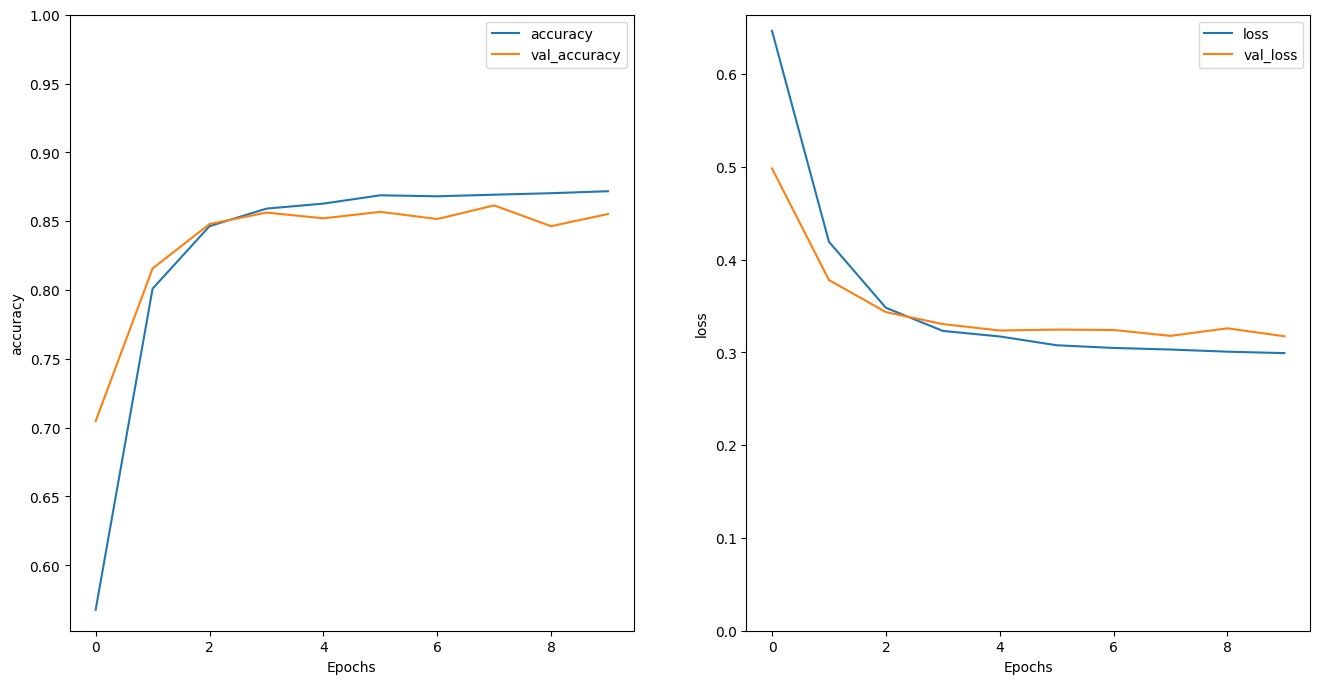

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [16]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 10s 10s/step
[-0.02432198]


#Stack two or more LSTM layers
Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 81s 156ms/step - loss: 0.6469 - accuracy: 0.5640 - val_loss: 0.4787 - val_accuracy: 0.7844
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.4070 - accuracy: 0.8237 - val_loss: 0.3757 - val_accuracy: 0.8333
Epoch 3/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3485 - accuracy: 0.8518 - val_loss: 0.3526 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3266 - accuracy: 0.8620 - val_loss: 0.3292 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3167 - accuracy: 0.8673 - val_loss: 0.3406 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3119 - accuracy: 0.8687 - val_loss: 0.3260 - val_accuracy: 0.8469
Epoch 7/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3080 - accuracy: 0.8698 - val_loss: 0.3197 - val_ac

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3218 - accuracy: 0.8476
Test Loss: 0.32184261083602905
Test Accuracy: 0.8475599884986877


In [21]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8640993]]


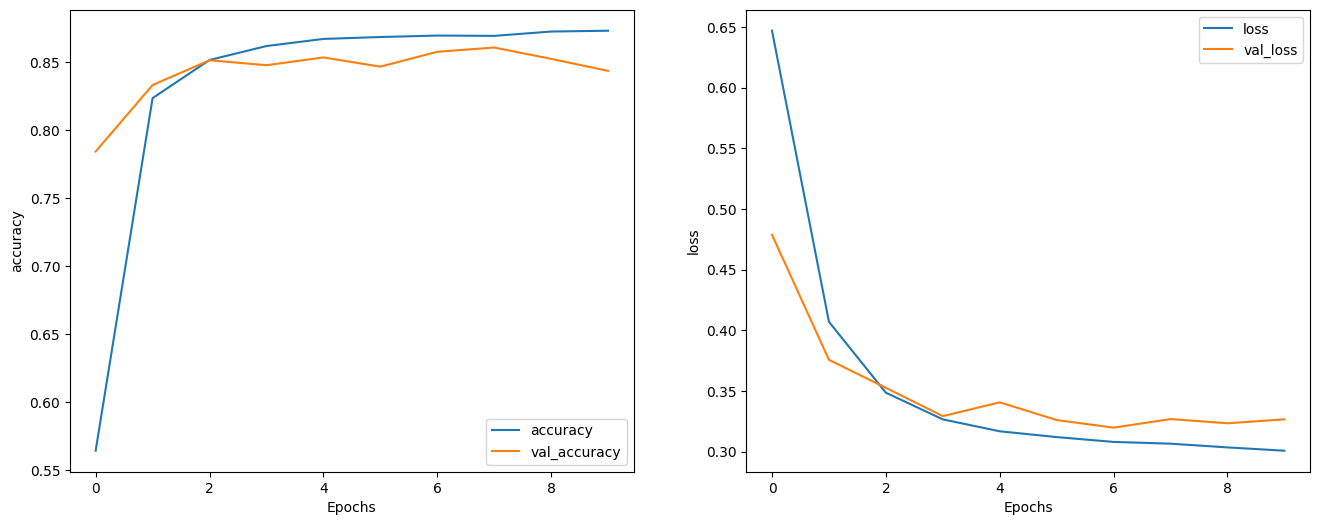

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')